In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pyensembl import EnsemblRelease
import gseapy as gp
import os


In [2]:
LOG2FC_PSEUDOCOUNT = 0.5

In [4]:
def calculate_log2_fc(df, pseudocount=0.5):
    return np.log2((df['upregulated'] + pseudocount) / (df['downregulated'] + pseudocount))

def perform_fisher_exact(row, total_up, total_down):
    a = row['upregulated']
    b = row['downregulated']
    c = total_up - a
    d = total_down - b
    # Construct contingency table
    table = [[a, b],
             [c, d]]
    # Perform Fisher's Exact Test
    oddsratio, p_value = stats.fisher_exact(table, alternative='two-sided')
    return pd.Series({'odds_ratio': oddsratio, 'p_value': p_value})

def calculate_z_score(df):
    # Calculate mean and standard deviation of log2 fold changes
    mean_log2fc = df['log2_fc'].mean()
    std_log2fc = df['log2_fc'].std()
    
    # Calculate Z-score
    z_scores = (df['log2_fc'] - mean_log2fc) / std_log2fc
    
    # Return a Series of Z-scores
    return pd.Series(z_scores, index=df.index, name='z_score')

def get_gene_details(df, gene_id_column, release=75):
    # Initialize Ensembl data for the specified release
    ensembl = EnsemblRelease(release)
    
    def fetch_details(gene_id):
        try:
            gene = ensembl.gene_by_id(gene_id)
            return {
                'gene_id': gene.gene_id,
                'gene_name': gene.gene_name,
                'biotype': gene.biotype,
            }
        except ValueError:
            return {
                'gene_id': None,
                'gene_name': None,
                'biotype': None,
            }
    
    # Apply the function to each gene ID in the column
    gene_details = df[gene_id_column].apply(fetch_details)
    
    # Convert the result to a DataFrame
    details_df = pd.DataFrame(gene_details.tolist())
    

    
    return pd.merge(df, details_df, on='gene_id', how='left')

def generate_regulation_column(df):
    df['regulation'] = np.select(
        [df['pred_difference'] > 0, df['pred_difference'] < 0],
        ['downregulated', 'upregulated'],
        default='no_change'
    )
    return df

def pivot_df(df):
    return df.groupby('gene_id')['regulation'].value_counts().unstack(fill_value=0).reset_index()

def calculate_fisher_exact_pvalue(df):

    total_upregulated = df['upregulated'].sum()
    total_downregulated = df['downregulated'].sum()
    
    # Create 2x2 contingency tables for all rows
    tables = np.array([
        df['upregulated'],
        df['downregulated'],
        total_upregulated - df['upregulated'],
        total_downregulated - df['downregulated']
    ]).T.reshape(-1, 2, 2)
    
    # Perform Fisher's exact test for all contingency tables and extract only p-values
    p_values = np.array([stats.fisher_exact(table, alternative='two-sided')[1] for table in tables])
    
    # Return a Series of p-values
    return pd.Series(p_values, index=df.index, name='p_value')

def run_gsea_preranked(df, gene_column='gene_name', rank_column='rank', gene_sets='GO_Biological_Process_2021', 
                       outdir='enrichr', threads=4, permutation_num=1000, min_size=5, max_size=1000):
    
    # ensure outdir exists
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    # Create a Series with gene names as index and ranks as values
    ranked_genes = df.set_index(gene_column)[rank_column]

    # Run preranked GSEA
    pre_res = gp.prerank(rnk=ranked_genes, 
                         gene_sets=gene_sets,
                         threads=threads,
                         permutation_num=permutation_num,
                         min_size=min_size,
                         max_size=max_size,
                         outdir=outdir,
                         verbose=True,
                         format='png')

    # Get the results and sort them
    results = pre_res.res2d
    sorted_results = results.sort_values('NES', ascending=False)

    return pre_res, sorted_results



def calculate_gsea_rank(df, log2_odds_ratio_col='log2_fc', p_adj_col='p_adj', clip_value=1e10):

    # Calculate initial rank
    rank = df[log2_odds_ratio_col] * (-np.log10(df[p_adj_col]))
    
    # Clip extreme values
    rank = rank.clip(lower=-clip_value, upper=clip_value)
    
    # Add small random values to break ties
    rank += np.random.random(len(df)) * 1e-10
    
    return pd.Series(rank, index=df.index, name='rank')

def run_pipeline(data, gene_set='KEGG_2021_Human'):
    
    if data.endswith(".parquet"):
        df = pd.read_parquet(data)
    else:  
        df = pd.read_csv(data)

    df = generate_regulation_column(df)
    df = pivot_df(df)

    # drop not_found
    df = df[df.gene_id != "not_found"]

    df.loc[:, "log2_fc"] = calculate_log2_fc(df, LOG2FC_PSEUDOCOUNT)
    df.loc[:, 'p_value'] = calculate_fisher_exact_pvalue(df)
    df.loc[:, 'p_adj'] = multipletests(df['p_value'], method='fdr_bh')[1]
    df.loc[:, 'z_score'] = calculate_z_score(df)
    df.loc[:, 'rank'] = calculate_gsea_rank(df)

    df = get_gene_details(df, 'gene_id')

    pre_res, sorted_results = run_gsea_preranked(df, gene_sets=gene_set)

    print(f"The number of gene sets with FDR q-value < 0.25 is {len(sorted_results[sorted_results['FDR q-val'] < 0.25])}")
    
    return pre_res, sorted_results, sorted_results[sorted_results['FDR q-val'] < 0.25]



In [5]:
data = "data/synth/all.parquet"

pre_res, all, significant = run_pipeline(data, gene_set='KEGG_2021_Human')

2024-10-04 00:24:50,647 [INFO] Input gene rankings contains duplicated IDs
2024-10-04 00:24:50,651 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-10-04 00:24:50,652 [INFO] Parsing data files for GSEA.............................
2024-10-04 00:24:51,858 [INFO] Downloading and generating Enrichr library gene sets......
2024-10-04 00:25:01,336 [INFO] 0003 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-10-04 00:25:01,337 [INFO] 0317 gene_sets used for further statistical testing.....
2024-10-04 00:25:01,338 [INFO] Start to run GSEA...Might take a while..................
2024-10-04 00:25:09,527 [INFO] Start to generate gseapy reports, and produce figures...
2024-10-04 00:25:09,528 [INFO] Congratulations. GSEApy runs successfully................



The number of gene sets with FDR q-value < 0.25 is 0


In [6]:
all.sort_values('FDR q-val')


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
15,prerank,Phospholipase D signaling pathway,0.566025,1.350206,0.036603,0.754579,0.997,27/139,16.10%,CXCR1;SHC3;JMJD7-PLA2G4B;RAPGEF3;DGKA;PLD1;CXC...
14,prerank,Cholinergic synapse,0.586547,1.351534,0.058462,0.794986,0.997,21/103,19.75%,JAK2;CHRM1;GNB1;CACNA1C;ACHE;PRKCA;GNAI2;GNG12...
18,prerank,Cocaine addiction,0.666843,1.329636,0.084437,0.809923,0.999,9/44,12.42%,MAOB;PDYN;GRIN2B;GRIN3B;MAOA;GNAI2;GRM3;RGS9;TH
13,prerank,mRNA surveillance pathway,0.589127,1.352153,0.041348,0.844977,0.996,15/93,10.45%,MAGOH;NCBP2;CLP1;PABPN1;PNN;PPP2R5C;SMG5;HBS1L...
17,prerank,Mineral absorption,0.63916,1.329744,0.069132,0.85702,0.999,8/52,14.15%,FTH1;MT1F;SLC31A1;ATP2B3;SLC8A3;HEPH;STEAP1;TRPM6
...,...,...,...,...,...,...,...,...,...,...
258,prerank,Pentose and glucuronate interconversions,0.426392,0.788583,0.781513,1.0,1.0,6/24,17.75%,UGP2;RPE;AKR1B10;UGT2B7;UGT1A6;DHDH
259,prerank,RNA transport,0.325499,0.782187,0.937226,1.0,1.0,19/147,12.06%,MAGOH;PRMT5;NCBP2;RANGAP1;NUP107;PNN;EIF2B1;XP...
260,prerank,Fatty acid degradation,0.384749,0.780431,0.796358,1.0,1.0,5/42,13.23%,CPT1B;ECI2;ALDH9A1;EHHADH;ECI1
312,prerank,DNA replication,-0.301829,-0.624428,0.977667,1.0,1.0,6/31,13.45%,POLE4;PRIM1;POLD2;MCM4;RNASEH2B;RNASEH1


GSEA paper

https://www.pnas.org/doi/abs/10.1073/pnas.0506580102

https://www.pathwaycommons.org/guide/primers/data_analysis/gsea/

![alt text](<Screenshot 2024-09-30 at 18-50-03 Gene Set Enrichment Analysis · Pathway Guide.png>)

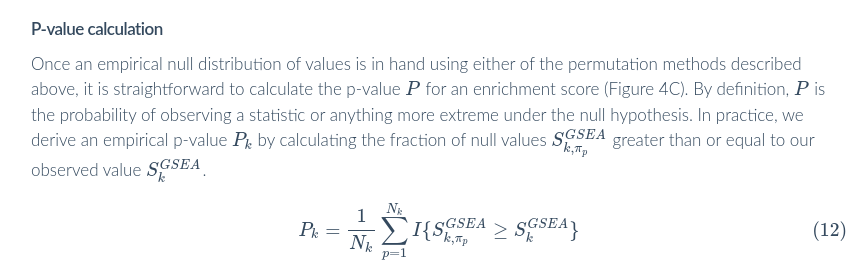

In [ ]:
gsea_results = run_gsea_preranked(df, gene_sets=['KEGG_2021_Human'], permutation_num=1000)


https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideTEXT.htm#_GSEAPreranked_Page

●     Number of permutations. Specify the number of gene_set permutations to perform in assessing the statistical significance of the enrichment score. It is best to start with a small number, such as 10. After the analysis completes successfully, run it again with a full set of permutations. The GSEA recommends 1000 gene_set permutations.

https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideTEXT.htm

## Interpreting GSEA Results

### NES

The normalized enrichment score (NES) is the primary statistic for examining gene set enrichment results. By normalizing the enrichment score, GSEA accounts for differences in gene set size and in correlations between gene sets and the expression dataset; therefore, the normalized enrichment scores (NES) can be used to compare analysis results across gene sets.

### FDR

The GSEA analysis report highlights enrichment gene sets with an FDR of less than 25% as those most likely to generate interesting hypotheses and drive further research, but provides analysis results for all analyzed gene sets. In general, given the lack of coherence in most expression datasets and the relatively small number of gene sets being analyzed, an FDR cutoff of 25% is appropriate. However, if you have a small number of samples and use gene_set permutation (rather than phenotype permutation) for your analysis, you are using a less stringent assessment of significance and would then want to use a more stringent FDR cutoff, such as 5%.

> we are using permutation so 25% FDR is ok

Because the goal of GSEA is to generate hypotheses, the GSEA team recommends focusing on the FDR statistic.


### NOM p-value

Nominal p value; that is, the statistical significance of the enrichment score. The nominal p value is not adjusted for gene set size or multiple hypothesis testing; therefore, it is of limited use in comparing gene sets.

## optimal values

https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideTEXT.htm#_GSEA_Report

enriched gene sets that are significant, as indicated by a false discovery rate (FDR) of less than 25%. Typically, these are the gene sets most likely to generate interesting hypotheses and drive further research. 

enriched gene sets with a nominal p value of less than 1% and of less than 5%. The nominal p value is not adjusted for gene set size or multiple hypothesis testing; therefore, it is of limited value for comparing gene sets.

In [ ]:
print(f"The number of gene sets with FDR q-value < 0.25 is {len(gsea_results[gsea_results['FDR q-val'] < 0.25])}")